# PDE, physics and geometry

## The description of the problem
The problem we consider is a well-known benchmark for Navier-Stokes solvers known under the name "lid-driven cavity". Physically it corresponds to a situation when a steam of incompressible fluid flow in the channel at a constant speed and liquid in the cavity on the side of the channel that is initially at rest. The channel is not modeled and inters equation only through the boundary condition on the "lid" (i.e., the upper part) of the cavity.

In our case, we focus on the situation when the form of the cavity changes from problem to problem, and the goal is to predict velocity $v^1(t^{\star}, x^{1}, x^{2})$ and $v^{2}(t^{\star}, x^{1}, x^{2})$ field at time $t^{\star}$ for a given cavity geometry with a boundary $C(x^{1}, x^{2}) = L(x^{1}, x^{2})\cup \Gamma (x^{1}, x^{2})$ where $L(x^{1}, x^{2})$ represents the lid and $\Gamma(x^{1}, x^{2})$ represents the rest of the cavity.

So the set of equations that we solve 
$$
	\frac{\partial v^{i}}{\partial t} = \frac{\partial}{\partial x^{k}}\left(-v^{k} v^{i} - p + \nu \frac{\partial v^{i}}{\partial x^k}\right)
$$

$$
	\frac{\partial v^{k}}{\partial x^{k}} =0
$$

$$
	\left.p(t,x)\right|_{x\in L} = 0,\,\left.\frac{\partial p(t, x)}{\partial x^{i}}n^{i}\right|_{x \in \Gamma} = 0
$$
$$
	\left.v^{1}(t, x)\right|_{x\in L} = 1,\,\left.v^{2}(t, x)\right|_{x\in C} = \left.v^{1}(t, x)\right|_{x\in \Gamma} = 0
$$
where $n$ is an outward normal to the boundary.

## Physical and computational domains

The domain is defined with a transfinite interpolation from randomly generated boundary curves
$x^{1}(\xi^{1}, 0) = \xi^{1}, x^{1}(\xi^{1}, 1) = \xi^{1}, x^{2}(0, \eta) = \xi^{2}, y(1, \xi^{2}) = \xi^{2}$
$x^{1}(0, \xi^{2}) = \sum_{i=1}^{m}\sin(\pi \xi^{2} (k+1) c^k \big/(10(k+1)^2), x^{1}(1, \xi^{2}) = 1 + \xi^{2}(1-\xi^{2})\alpha/2$
$x^{2}(\xi^{1}, 0) = \sum_{i=1}^{m}\sin(\pi \xi^{1} (k+1) d^k \big/(10(k+1)^2), x^{2}(\xi^{1}, 1) = 1$
where $d^{k}, c^{k}, \alpha$ are sampled from standard normal distribution and $\xi^{1}, \xi^{2}\in[0, 1]^2$.

## General covariance augmentation

The problem is already given in the curvilinear coordinate system. So the input features are geometries $x^{i}(\xi)$ and the targets are contravariant components of the velocity field $\overline{v}^{j}(\xi) = \frac{\partial \xi^{j}}{\partial x^{\alpha}} v^{\alpha}(\xi)$. The augmentation is then straightforward:
1. Generate random transformation from square to square $\xi^{i} = \xi^{i}(\eta^{i})$
2. Modify feature and target $x^{i}(\xi^{j}(\eta^{j}))$, $\overline{v}^{j}(\eta) = \frac{\partial \eta^{j}}{\partial \xi^{\alpha}}\overline{v}^{\alpha}(\xi(\eta))$


## Solver

To integrate the equation we use the Chorin projection method that works in three steps

1. Advance speed neglecting pressure term
\begin{equation}
  \frac{u^{i} - v^{i}_{(n)}}{\Delta t} = \frac{\partial}{\partial x^{k}}\left(-v^{k}_{(n)} v^{i}_{(n)} + \nu \frac{\partial v^{i}_{(n)}}{\partial x^k}\right)
\end{equation}

2. Solve the Poisson equation to obtain pressure correction term
\begin{equation}
  \begin{split}
    \frac{\partial}{\partial x^{k}}\frac{\partial p}{\partial x^{k}} &= \frac{\partial u^{k}}{\partial x^{k}},\\
    p(x, 1) &= 0,\,\frac{\partial p(x, 0)}{\partial y} = \frac{\partial p(0, y)}{\partial x} = \frac{\partial p(1, y)}{\partial x} = 0.
  \end{split}
\end{equation}

3. Correct speed to restore incompressibility
\begin{equation}
    v^{i}_{(n+1)} = u^{i} - \frac{\partial p}{\partial x^{i}}
\end{equation}

Each step:

1. We need to solve the Poisson equation

2. Perform update that contains various derivatives

For both tasks, we will use finite-difference discretization.

## Chorin projection method in the curvilinear coordinates

Under the coordinate transformations, the equation for pressure changes to

\begin{equation}
  \begin{split}
    &\frac{\partial}{\partial \xi^{i}}\left(J\delta^{\alpha\beta}\frac{\partial \xi^{i}}{\partial x^{\alpha}}\frac{\partial \xi^{j}}{\partial x^{\beta}}\frac{\partial p}{\partial \xi^{j}}\right) = \frac{\partial}{\partial \xi^{j}}\left(\overline{u}^{j} J\right),\,\overline{u}^{j} = \frac{\partial \xi^{j}}{\partial x^{\alpha}} u^{\alpha},\\
    & p\left(\xi^{1}, 1\right) = 1,\,\left(\frac{\partial p}{\partial \xi^{1}}\frac{\partial \xi^{1}}{\partial x^2} + \frac{\partial p}{\partial \xi^{2}}\frac{\partial \xi^{2}}{\partial x^2}\right)_{\xi^{2}=0} = 0,\\
    &\left(\frac{\partial p}{\partial \xi^{1}}\frac{\partial \xi^{1}}{\partial x^1} + \frac{\partial p}{\partial \xi^{2}}\frac{\partial \xi^{2}}{\partial x^1}\right)_{\xi^{1}=0} = 0,\\
    &\left(\frac{\partial p}{\partial \xi^{1}}\frac{\partial \xi^{1}}{\partial x^1} + \frac{\partial p}{\partial \xi^{2}}\frac{\partial \xi^{2}}{\partial x^1}\right)_{\xi^{1}=1} = 0.
  \end{split}
\end{equation}

The equation for speed update is a vector conservation law that has a form

\begin{equation}
    \frac{\partial A^{ij}}{\partial x^{j}} = F^{i},
\end{equation}

that transforms to

\begin{equation}
    \frac{\partial}{\partial \xi^{j}}\left(J \overline{A}^{ij}\right) + \frac{\partial^2 x^{l}}{\partial \xi^{k}\partial \xi^{j}}\frac{\partial \xi^{i}}{\partial x^{l}}\overline{A}^{kj} = \overline{F}^{i},\,\overline{A}^{kj} = \frac{\partial \xi^{k}}{\partial x^{\alpha}}\frac{\partial \xi^{j}}{\partial x^{\beta}}A^{\alpha\beta},\,\overline{F}^{j} = \frac{\partial \xi^{j}}{\partial x^{\alpha}}F^{\alpha}.
\end{equation}

More specifically, we have

\begin{equation}
  \frac{u^{i} - v^{i}_{(n)}}{\Delta t} = \frac{\partial}{\partial x^{k}}\left(-v^{k}_{(n)} v^{i}_{(n)} + \nu \frac{\partial v^{i}_{(n)}}{\partial x^k}\right),
\end{equation}

so the most problematic term is 

\begin{equation}
  \frac{\partial v^{i}_{(n)}}{\partial x^k} \longrightarrow \frac{\partial \xi^{i}}{\partial x^{\alpha}}\frac{\partial \xi^{k}}{\partial x^{\beta}} \frac{\partial v^{\alpha}_{(n)}}{\partial x^\beta} = \frac{\partial \xi^{i}}{\partial x^{\alpha}}\frac{\partial \xi^{k}}{\partial x^{\beta}}\frac{\partial \xi^{\rho}}{\partial x^{\beta}} \frac{\partial v^{\alpha}_{(n)}}{\partial \xi^\rho}.
\end{equation}

To evaluate this term, we need to switch from $\overline{v}^{\alpha}$ to $v^{\alpha}$, and the rest is straightforward.

# Code and examples

We concocted this code within a week. It works. That is all we are proud of.

In [1]:
import jax.numpy as jnp
from jax import config, random, jit, vmap
from functools import partial, lru_cache
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import sympy as sp
import numpy as np
import scipy.sparse as sparse

In [2]:
@lru_cache
def get_large_grid(N):
    x = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, x, indexing="ij")
    return X, Y

@lru_cache
def get_inner_neighbours(N):
    lex = lambda i, j, N: i + N*j

    i = np.arange(N)
    j = np.arange(N-1)

    I_inner, J_inner = np.meshgrid(i, j, indexing="ij")
    I_inner, J_inner = I_inner[1:-1, 1:], J_inner[1:-1, 1:]
    I_inner = I_inner.reshape(-1, order="F")
    J_inner = J_inner.reshape(-1, order="F")

    J_ = J_inner + 1 
    North_mask = J_ < (N - 1)
    
    North = [lex(I_inner[North_mask], J_inner[North_mask], N), lex(I_inner[North_mask], J_[North_mask], N)]

    J_ = J_inner - 1 
    South_mask = J_ >= 0
    South = [lex(I_inner[South_mask], J_inner[South_mask], N), lex(I_inner[South_mask], J_[South_mask], N)]

    I_ = I_inner - 1
    West_mask = I_ >= 0
    West = [lex(I_inner[West_mask], J_inner[West_mask], N), lex(I_[West_mask], J_inner[West_mask], N)]

    I_ = I_inner + 1
    East_mask = I_ < N
    East = [lex(I_inner[East_mask], J_inner[East_mask ], N), lex(I_[East_mask], J_inner[East_mask], N)]

    Center = [lex(I_inner, J_inner, N), lex(I_inner, J_inner, N)]

    J_ = J_inner + 1
    I_ = I_inner - 1
    North_West_mask = North_mask * West_mask
    North_West = [lex(I_inner[North_West_mask], J_inner[North_West_mask], N), lex(I_[North_West_mask], J_[North_West_mask], N)]

    J_ = J_inner + 1
    I_ = I_inner + 1
    North_East_mask = North_mask * East_mask
    North_East = [lex(I_inner[North_East_mask], J_inner[North_East_mask], N), lex(I_[North_East_mask], J_[North_East_mask], N)]

    J_ = J_inner - 1
    I_ = I_inner - 1
    South_West_mask = South_mask * West_mask
    South_West = [lex(I_inner[South_West_mask], J_inner[South_West_mask], N), lex(I_[South_West_mask], J_[South_West_mask], N)]

    J_ = J_inner - 1
    I_ = I_inner + 1
    South_East_mask = South_mask * East_mask
    South_East = [lex(I_inner[South_East_mask], J_inner[South_East_mask], N), lex(I_[South_East_mask], J_[South_East_mask], N)]

    # second derivative
    row = [Center[0]]
    col = [Center[1]]

    # mixed derivative
    row += [North_East[0]]
    col += [North_East[1]]

    row += [South_West[0]]
    col += [South_West[1]]

    row += [North_West[0]]
    col += [North_West[1]]

    row += [South_East[0]]
    col += [South_East[1]]

    # second and first derivatives
    row += [North[0]]
    col += [North[1]]

    row += [South[0]]
    col += [South[1]]

    row += [East[0]]
    col += [East[1]]

    row += [West[0]]
    col += [West[1]]

    row = np.hstack(row)
    col = np.hstack(col)

    return North, South, West, East, Center, North_West, North_East, South_West, South_East, row, col

@lru_cache
def get_normal_boundary_neighbours(N):
    lex = lambda i, j, N: i + N*j

    I_south, J_south = np.arange(1, N-1), np.zeros((N-2,), dtype=np.int64)
    I_west, J_west = np.zeros((N-1,), dtype=np.int64), np.arange(N-1)
    I_east, J_east = np.zeros((N-1,), dtype=np.int64) + (N-1), np.arange(N-1)

    South_boundary = [lex(I_south, J_south, N), lex(I_south, J_south+1, N), lex(I_south, J_south+2, N)]
    West_boundary = [lex(I_west, J_west, N), lex(I_west+1, J_west, N), lex(I_west+2, J_west, N)]
    East_boundary = [lex(I_east, J_east, N), lex(I_east-1, J_east, N), lex(I_east-2, J_east, N)]

    row = [South_boundary[0],]*3 + [West_boundary[0],]*3 + [East_boundary[0],]*3
    col = South_boundary + West_boundary + East_boundary

    row = np.hstack(row)
    col = np.hstack(col)

    return South_boundary, West_boundary, East_boundary, row, col

@lru_cache
def get_tangent_boundary_neighbours(N):
    lex = lambda i, j, N: i + N*j

    I_south, J_south = np.arange(1, N-1), np.zeros((N-2,), dtype=np.int64)
    I_west, J_west = np.zeros((N-1,), dtype=np.int64), np.arange(N-1)
    I_east, J_east = np.zeros((N-1,), dtype=np.int64) + (N-1), np.arange(N-1)

    # dx on the South boundary = [points on the left, points on the right]
    South_boundary = [lex(I_south, J_south, N), lex(I_south-1, J_south, N), lex(I_south+1, J_south, N)]

    row = [South_boundary[0],]*2
    col = South_boundary[1:]

    # dy on the West boundary = [derivative at the south-west point, points on the bottom, points on the top]
    West_boundary = [lex(I_west, J_west, N), np.array([lex(0, 0, N), lex(0, 1, N), lex(0, 2, N)]), lex(I_west[1:], J_west[1:]-1, N), lex(I_west[1:-1], J_west[1:-1]+1, N)]

    row += [West_boundary[0][0],]*3 + [West_boundary[0][1:],] + [West_boundary[0][1:-1],]
    col += West_boundary[1:]

    # dy on the East boundary = [derivative at the wouth-east point, points on the bottom, points on the top]
    East_boundary = [lex(I_east, J_east, N), np.array([lex(N-1, 0, N), lex(N-1, 1, N), lex(N-1, 2, N)]), lex(I_east[1:], J_east[1:]-1, N), lex(I_east[1:-1], J_east[1:-1]+1, N)]

    row += [East_boundary[0][0],]*3 + [East_boundary[0][1:],] + [East_boundary[0][1:-1],]
    col += East_boundary[1:]

    row = np.hstack(row)
    col = np.hstack(col)

    return South_boundary, West_boundary, East_boundary, row, col

@lru_cache
def get_D_matrix(N):
    h = 1/(N-1)
    inner_points = np.arange(1, N-1)
    row = [inner_points, inner_points]
    col = [inner_points-1, inner_points+1]
    val = [-np.ones_like(inner_points)/2, np.ones_like(inner_points)/2]
    
    row += [[0, 0, 0], [N-1, N-1, N-1]]
    col += [[0, 1, 2], [N-1, N-2, N-3]]
    val += [[-3/2, 2, -1/2], [3/2, -2, 1/2]]

    row = np.hstack(row)
    col = np.hstack(col)
    val = np.hstack(val)/h

    A = sparse.coo_array((val, (row, col)), shape=(N, N)).tocsr()
    return A

@lru_cache
def get_D2_matrix(N):
    h = 1/(N-1)
    inner_points = np.arange(1, N-1)
    row = [inner_points, inner_points, inner_points]
    col = [inner_points-1, inner_points, inner_points+1]
    val = [np.ones_like(inner_points), -2*np.ones_like(inner_points), np.ones_like(inner_points)]

    row += [[0, 0, 0, 0], [N-1, N-1, N-1, N-1]]
    col += [[0, 1, 2, 3], [N-1, N-2, N-3, N-4]]
    val += [[2, -5, 4, -1], [2, -5, 4, -1]]

    row = np.hstack(row)
    col = np.hstack(col)
    val = np.hstack(val)/h**2

    A = sparse.coo_array((val, (row, col)), shape=(N, N)).tocsr()
    return A

def transfinite_interpolation(boundary_values):
    right, up, left, down = boundary_values
    M = len(right)
    z = np.linspace(0, 1, M)
    x, y = np.meshgrid(z, z, indexing='ij')
    horizontal = left*(1-x) + right*x
    mod_down = down - horizontal[:, 0]
    mod_up = up - horizontal[:, -1]
    vertical = (mod_down*(1-y).T).T + (mod_up*y.T).T
    return vertical + horizontal

def get_grid_diffs(x, y):
    # returns A[i, j] = dx_i / dxi_j, B[i, j] = dxi_i / dx_j, Jacobian, A[i, j, k] = d2x_i / dxi_j dxi_k

    N = x.shape[0]
    D1 = get_D_matrix(N)

    dx1_dxi1 = D1 @ x
    dx1_dxi2 = x @ D1.T
    dx2_dxi1 = D1 @ y
    dx2_dxi2 = y @ D1.T
    dx_dxi = np.stack([np.stack([dx1_dxi1, dx1_dxi2], 2), np.stack([dx2_dxi1, dx2_dxi2], 2)], 2)
    J = dx1_dxi1*dx2_dxi2 - dx1_dxi2*dx2_dxi1
    dxi_dx = np.linalg.inv(dx_dxi)

    D2 = get_D2_matrix(N)
    mixed_x = (D1 @ x) @ D1.T
    mixed_y = (D1 @ y) @ D1.T
    d2x1 = np.stack([np.stack([D2 @ x, mixed_x], 2), np.stack([mixed_x, x @ D2.T], 2)], 2)
    d2x2 = np.stack([np.stack([D2 @ y, mixed_y], 2), np.stack([mixed_y, y @ D2.T], 2)], 2)
    d2x_dxi = np.stack([d2x1, d2x2], 2)
    return dx_dxi, dxi_dx, J, d2x_dxi

def build_matrix_from_griddata(A11, A12, A22, Cw_, Dw_, Cs_, Ds_, Ce_, De_, N):
    '''
    to get values run
    X, Y = get_large_grid(N)
    A11 = a11(X, Y)
    A22 = a22(X, Y)
    A12 = a12(X, Y)

    Ds_ = Ds(X[1:-1, 0])
    Cw_ = Cw(Y[0, :-1])
    Ce_ = Ce(Y[-1, :-1])

    Cs_ = Cs(X[1:-1, 0])
    Dw_ = Dw(Y[0, :-1])
    De_ = De(Y[-1, :-1])
    '''
    North, South, West, East, Center, North_West, North_East, South_West, South_East, row, col = get_inner_neighbours(N)

    h = 1 / (N-1)

    A11_dx = -(np.roll(A11, 1, axis=0) - np.roll(A11, -1, axis=0)) / (2*h)
    A12_dy = -(np.roll(A12, 1, axis=1) - np.roll(A12, -1, axis=1)) / (2*h)
    A12_dx = -(np.roll(A12, 1, axis=0) - np.roll(A12, -1, axis=0)) / (2*h)
    A22_dy = -(np.roll(A22, 1, axis=1) - np.roll(A22, -1, axis=1)) / (2*h)

    A11 = A11.reshape(-1, order="F")
    A22 = A22.reshape(-1, order="F")
    A12 = A12.reshape(-1, order="F")
    A11_dx = A11_dx.reshape(-1, order="F")
    A12_dy = A12_dy.reshape(-1, order="F")
    A12_dx = A12_dx.reshape(-1, order="F")
    A22_dy = A22_dy.reshape(-1, order="F")
    
    # second derivative
    val = [-(A11[Center[0]] + A22[Center[0]])*2/h**2]

    # mixed derivative
    val += [A12[North_East[0]]/(2*h**2)]
    val += [A12[South_West[0]]/(2*h**2)]
    val += [-A12[North_West[0]]/(2*h**2)]
    val += [-A12[South_East[0]]/(2*h**2)]

    # second and first derivatives
    val += [(A22[North[0]])/h**2 + (A22_dy[North[0]] + A12_dx[North[0]])/(2*h)]
    val += [(A22[South[0]])/h**2 - (A22_dy[South[0]] + A12_dx[South[0]])/(2*h)]
    val += [(A11[East[0]])/h**2 + (A11_dx[East[0]] + A12_dy[East[0]])/(2*h)]
    val += [(A11[West[0]])/h**2 - (A11_dx[West[0]] + A12_dy[West[0]])/(2*h)]

    val = np.hstack(val)

    # derivatives in normal directions Cw, Ds, Ce
    South_boundary, West_boundary, East_boundary, row_bc, col_bc = get_normal_boundary_neighbours(N)

    val_bc = [-3/2*Ds_, 2*Ds_, -1/2*Ds_]
    val_bc += [-3/2*Cw_, 2*Cw_, -1/2*Cw_]
    val_bc += [3/2*Ce_, -2*Ce_, 1/2*Ce_]
    val_bc = np.hstack(val_bc) / h

    # derivatives in tangent directions Dw, Cs, De
    South_boundary, West_boundary, East_boundary, row_bc_n, col_bc_n = get_tangent_boundary_neighbours(N)

    val_bc_n = [-Cs_/2, Cs_/2]
    val_bc_n += [-3/2*Dw_[0], 2*Dw_[0], -1/2*Dw_[0]] + [-Dw_[1:]/2, Dw_[1:-1]/2]
    val_bc_n += [-3/2*De_[0], 2*De_[0], -1/2*De_[0]] + [-De_[1:]/2, De_[1:-1]/2]
    val_bc_n = np.hstack(val_bc_n) / h

    val = np.hstack([val, val_bc, val_bc_n])
    row = np.hstack([row, row_bc, row_bc_n])
    col = np.hstack([col, col_bc, col_bc_n])

    A = sparse.coo_array((val, (row, col)), shape=(N*(N-1), N*(N-1))).tocsr()
    return A

@lru_cache
def get_dense_D_matrix(N):
    return get_D_matrix(N).toarray()

def fields_init(N):
    v = np.zeros((N, N, 2))
    v[:, -1, 0] = 1
    return v

def half_update(v, nu, dt, dxi_dx, dx_dxi, J, Gamma, g):
    N = v.shape[0]
    D1 = get_dense_D_matrix(N)
    v_ = np.einsum("abcd, abd -> abc", dx_dxi, v)
    v_dxi = np.stack([np.einsum("ab, bde -> ade", D1, v_), np.einsum("ab, dbe -> dae", D1, v_)], 3) # dv_i / dxi_j
    v_dxi = np.einsum("abcd, abdf -> abcf", dxi_dx, v_dxi)
    v_dxi = nu*np.einsum("abcd, abdf -> abcf", v_dxi, g) - np.einsum("abc, abd -> abcd", v, v)
    v += dt * np.einsum("ab, bcd -> acd", D1, J.reshape(N, N, 1) * v_dxi[:, :, :, 0])
    v += dt * np.einsum("ab, cbd -> cad", D1, J.reshape(N, N, 1) * v_dxi[:, :, :, 1])
    v += dt * np.einsum("abcde, abde -> abc", Gamma, v_dxi)
    v[0, :, :] = 0
    v[-1, :, :] = 0
    v[:, 0, :] = 0
    v[:, -1, 0] = 1
    return v

def solve_for_pressure(v, A_lu, J):
    N = v.shape[0]
    D1 = get_D_matrix(N)
    rhs = (D1 @ (v[:, :, 0] * J) + (v[:, :, 1] * J) @ D1.T)
    rhs[0, :] = 0
    rhs[-1, :] = 0
    rhs[:, 0] = 0
    rhs = rhs[:, :-1].reshape(-1, order="F")

    pressure = A_lu.solve(rhs)
    pressure = np.hstack([pressure, np.zeros((N,))])
    pressure = pressure.reshape(v[:, :, 0].shape, order="F")
    return pressure

def full_update(v, p):
    D1 = get_D_matrix(N)
    v[:, :, 0] -= D1 @ p
    v[:, :, 1] -= p @ D1.T
    v[0, :, :] = 0
    v[-1, :, :] = 0
    v[:, 0, :] = 0
    v[:, -1, 0] = 1
    return v

def get_grid(N):
    N1 = 6
    xi = jnp.linspace(0, 1, N)
    coeff1 = np.random.randn(N1) / np.arange(1, N1+1)**2
    coeff2 = np.random.randn(N1) / np.arange(1, N1+1)**2

    down_x = xi
    up_x = xi
    left_x = np.sum(np.stack([np.sin(np.pi*(k+1)*xi)*coeff1[k] for k in range(N1)], 0), 0)*0.1
    right_x = 1 + xi*(1-xi)*np.random.randn()*0.5

    down_y = np.sum(np.stack([np.sin(np.pi*(k+1)*xi)*coeff2[k] for k in range(N1)], 0), 0)*0.1
    up_y = np.zeros((N, )) + 1
    left_y = xi
    right_y = xi

    x = transfinite_interpolation([right_x, up_x, left_x, down_x])
    y = transfinite_interpolation([right_y, up_y, left_y, down_y])

    return x, y

## Solution for non-deformed cavity

Example of the solution for rectangular cavity.

In [3]:
N = 100
M = 2000
dt = 0.0001
nu = 0.01

# define grid
xi = np.linspace(0, 1, N)

down_x = xi
up_x = xi
left_x = 0*xi
right_x = 1 + 0*xi

down_y = 0*xi
up_y = 1 + 0*xi
left_y = xi
right_y = xi

X = transfinite_interpolation([right_x, up_x, left_x, down_x])
Y = transfinite_interpolation([right_y, up_y, left_y, down_y])

# get grid derivatives
dx_dxi, dxi_dx, J, d2x_dxi = get_grid_diffs(X, Y)

# find functions for Poisson equation
A = J.reshape(N, N, 1, 1)*np.einsum("abcd, abed -> abce", dxi_dx, dxi_dx)
A11 = A[:, :, 0, 0]
A12 = A[:, :, 0, 1]
A22 = A[:, :, 1, 1]

Cw_ = dxi_dx[0, :-1, 0, 0] # xi1 west
Dw_ = dxi_dx[0, :-1, 1, 0] # xi2 west
Cs_ = dxi_dx[1:-1, 0, 0, 1] # xi1 south
Ds_ = dxi_dx[1:-1, 0, 1, 1] # xi2 south
Ce_ = dxi_dx[-1, :-1, 0, 0] # xi1 east
De_ = dxi_dx[-1, :-1, 1, 0] # xi2 east

A = build_matrix_from_griddata(A11, A12, A22, Cw_, Dw_, Cs_, Ds_, Ce_, De_, N)

# find functions for half step
Gamma = np.einsum("abcd, abdef -> abcef", dxi_dx, d2x_dxi)
g = np.einsum("abcd, abed -> abce", dxi_dx, dxi_dx)

Xi, Eta = get_large_grid(N)
v = fields_init(N)
A_lu = sparse.linalg.splu(A)

for i in range(M):
    v = half_update(v, nu, dt, dxi_dx, dx_dxi, J, Gamma, g)
    p = solve_for_pressure(v, A_lu, J)
    v = full_update(v, p)

/usr/local/lib/python3.9/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


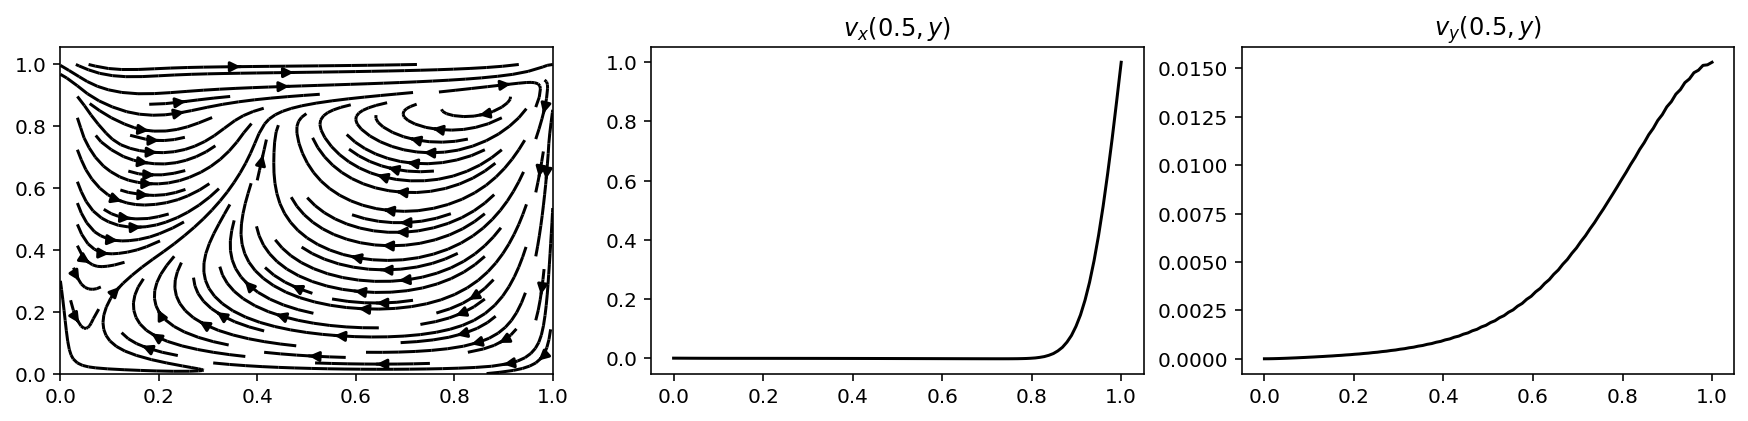

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].streamplot(Xi.T, Eta.T, v[:, :, 0].T, v[:, :, 1].T, color="black")
ax[1].plot(Eta[50, :], v[50, :, 0], color="black")
ax[2].plot(Y[50, :], v[50, :, 1], color="black")
ax[1].set_title("$v_x(0.5, y)$")
ax[2].set_title("$v_y(0.5, y)$");

## Solutions for deformed cavity

Example of the solution for the non-rectangular cavity (the streamplot is given in the $\xi^{1},\xi^{2}$ coordinates).

In [5]:
N = 100
M = 2000
dt = 0.0001
nu = 0.01

# define grid
xi = np.linspace(0, 1, N)

down_x = xi
up_x = xi
left_x = np.sin(5*np.pi*xi)*0.05
right_x = 1 + xi*(1-xi)*0.5

down_y = -np.sin(3*np.pi*xi)*0.02
up_y = np.zeros((N, )) + 1
left_y = xi
right_y = xi

X = transfinite_interpolation([right_x, up_x, left_x, down_x])
Y = transfinite_interpolation([right_y, up_y, left_y, down_y])

# get grid derivatives
dx_dxi, dxi_dx, J, d2x_dxi = get_grid_diffs(X, Y)

# find functions for Poisson equation
A = J.reshape(N, N, 1, 1)*np.einsum("abcd, abed -> abce", dxi_dx, dxi_dx)
A11 = A[:, :, 0, 0]
A12 = A[:, :, 0, 1]
A22 = A[:, :, 1, 1]

Cw_ = dxi_dx[0, :-1, 0, 0] # xi1 west
Dw_ = dxi_dx[0, :-1, 1, 0] # xi2 west
Cs_ = dxi_dx[1:-1, 0, 0, 1] # xi1 south
Ds_ = dxi_dx[1:-1, 0, 1, 1] # xi2 south
Ce_ = dxi_dx[-1, :-1, 0, 0] # xi1 east
De_ = dxi_dx[-1, :-1, 1, 0] # xi2 east

A = build_matrix_from_griddata(A11, A12, A22, Cw_, Dw_, Cs_, Ds_, Ce_, De_, N)

# find functions for half step
Gamma = np.einsum("abcd, abdef -> abcef", dxi_dx, d2x_dxi)
g = np.einsum("abcd, abed -> abce", dxi_dx, dxi_dx)

Xi, Eta = get_large_grid(N)
v = fields_init(N)
A_lu = sparse.linalg.splu(A)

for i in range(M):
    v = half_update(v, nu, dt, dxi_dx, dx_dxi, J, Gamma, g)
    p = solve_for_pressure(v, A_lu, J)
    v = full_update(v, p)

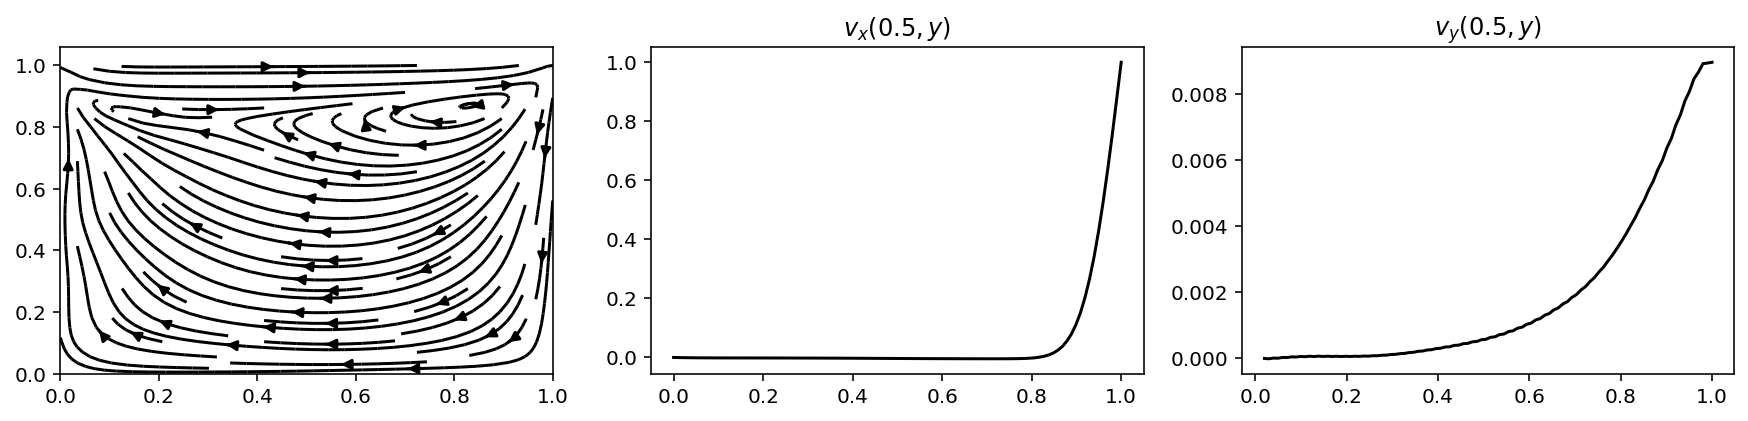

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].streamplot(Xi.T, Eta.T, v[:, :, 0].T, v[:, :, 1].T, color="black")
ax[1].plot(Eta[50, :], v[50, :, 0], color="black")
ax[2].plot(Y[50, :], v[50, :, 1], color="black")
ax[1].set_title("$v_x(0.5, y)$")
ax[2].set_title("$v_y(0.5, y)$");

## Random cavities

In [7]:
N = 4**3
xi = jnp.linspace(0, 1, N)
N_samples = 5

grid = []
for i in range(N_samples**2):
    x, y = get_grid(N)
    grid.append([x, y])

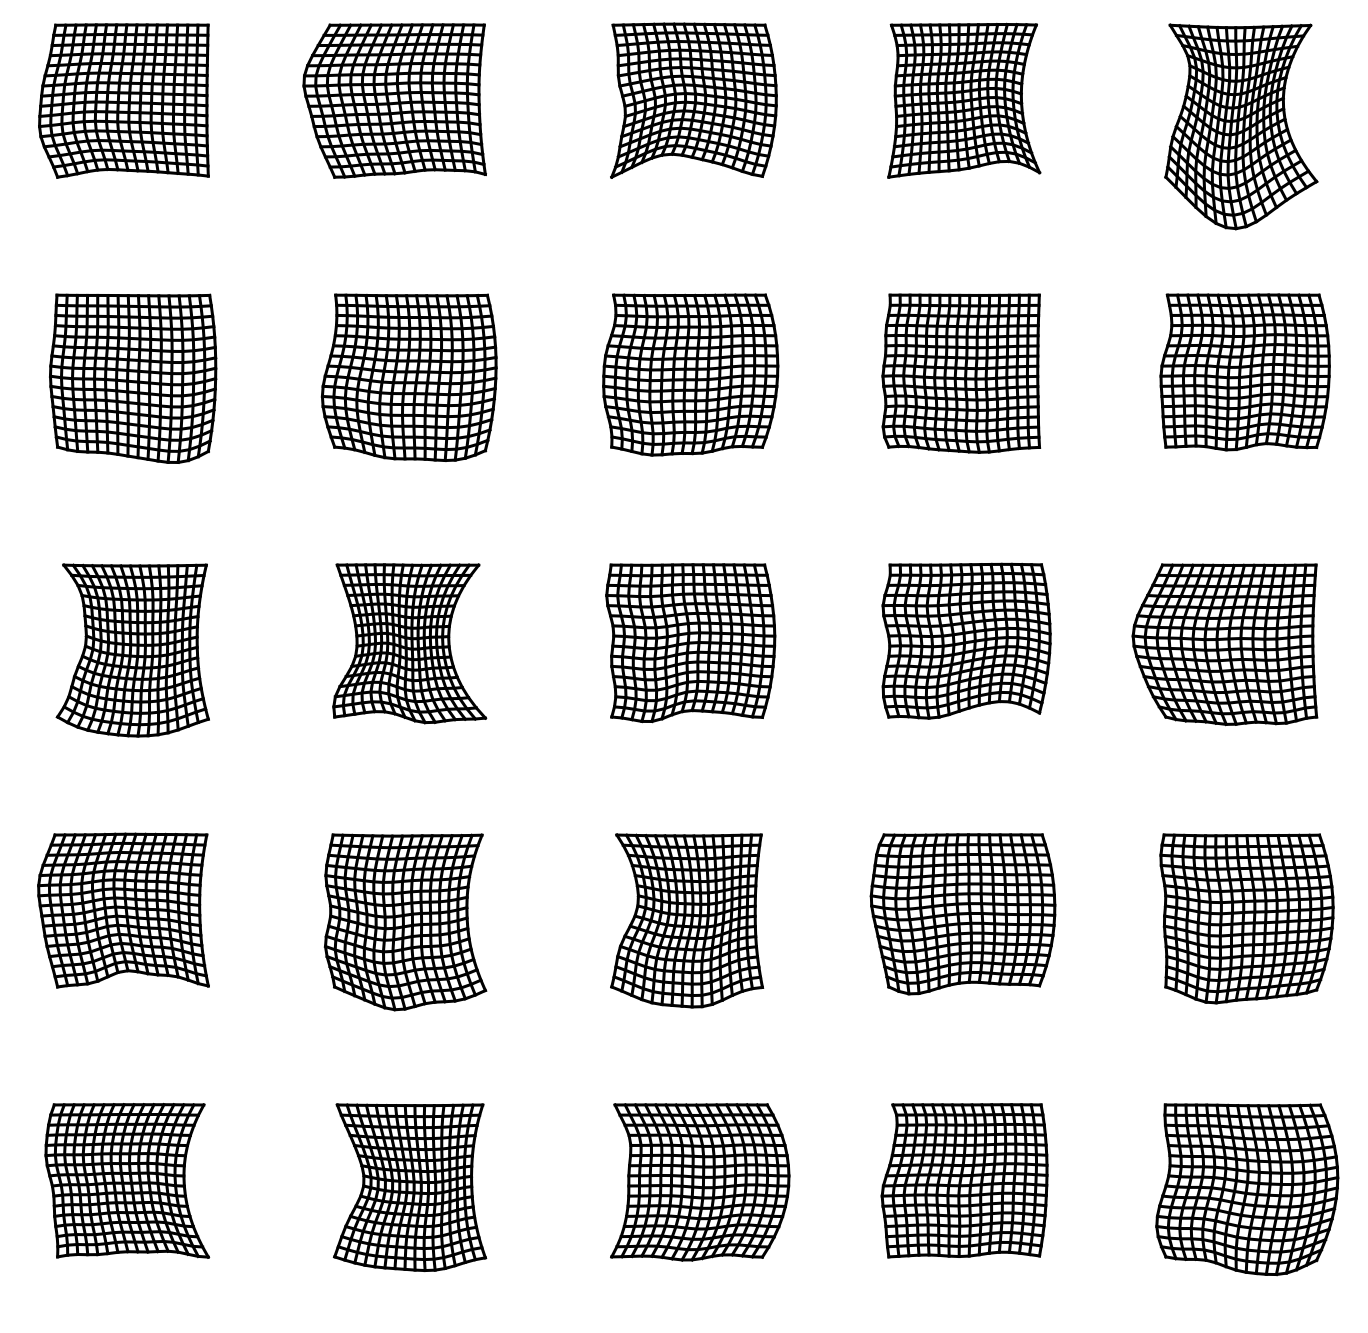

In [8]:
fig, ax = plt.subplots(N_samples, N_samples, figsize=(12, 12), sharex=True, sharey=True)

for a, g in zip(ax.reshape(-1), grid):
    a.plot(g[0][::4, ::4], g[1][::4, ::4], color="black")
    a.plot(g[0][::4, ::4].T, g[1][::4, ::4].T, color="black")
    a.axis("off")

## Composition of grids

**To run the code below, do not forget to supply the augmentation code that comes with the preprint!**

In [10]:
from augmentation import coordinate_transforms
from scipy.interpolate import griddata

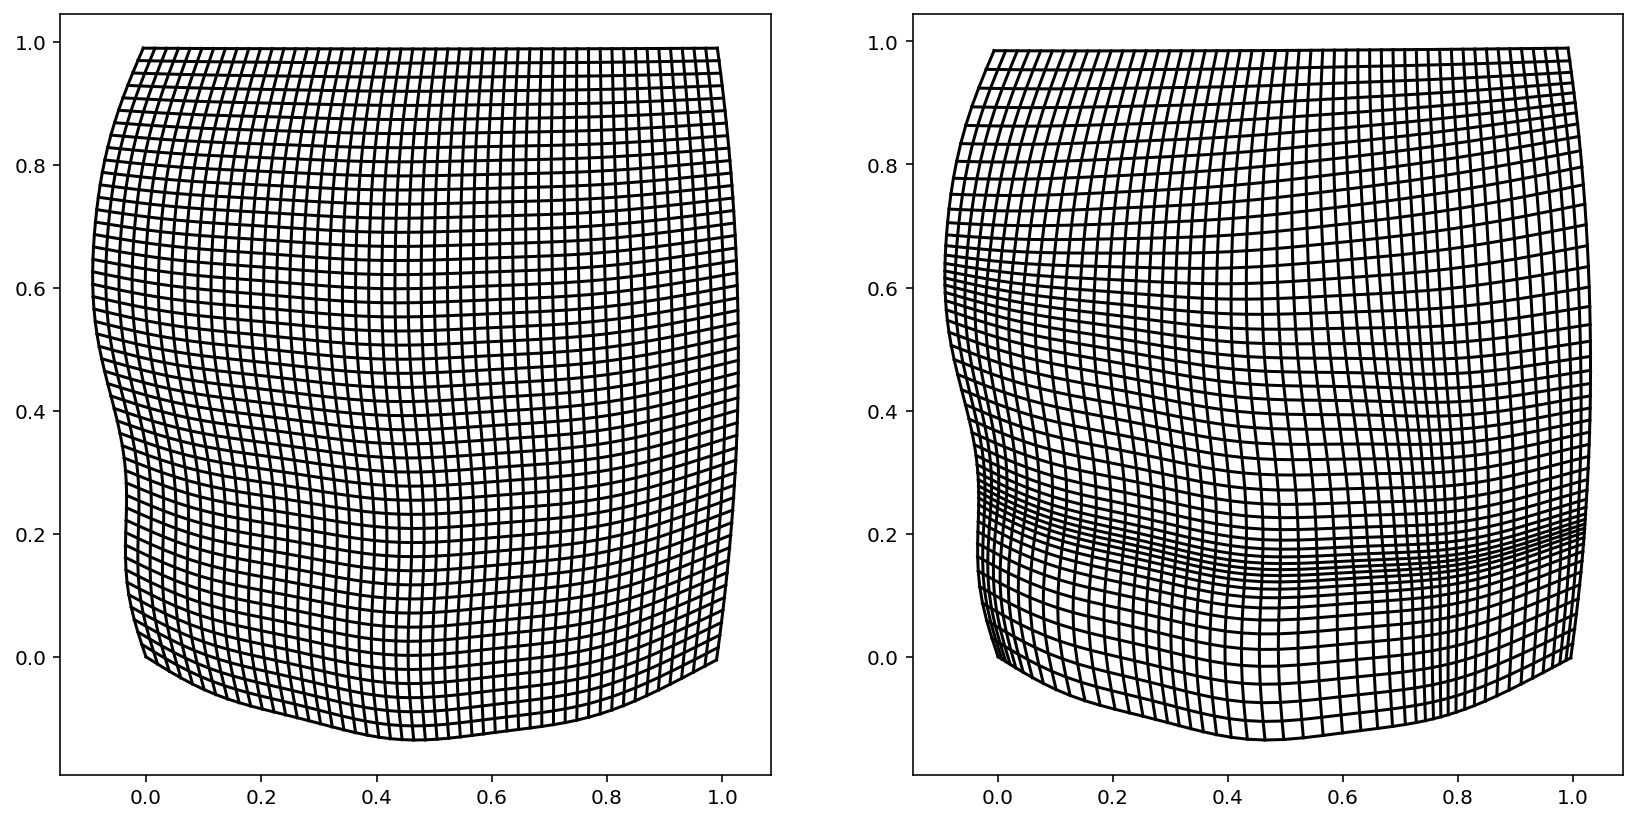

In [11]:
M = 3
N = 100
xi = jnp.linspace(0, 1, N)
eta = jnp.linspace(0, 1, N)

key = random.PRNGKey(12)
keys = random.split(key)

keys = random.split(keys[-1], 5)
A_list = [coordinate_transforms.build_matrix(xi, M), coordinate_transforms.build_matrix(eta, M)]
coeff_list = [coordinate_transforms.get_coeff(key, M, beta=1e-2) for key in keys[:-1]]
eps = [1, 0, 1, 1]
coeff_list = [jnp.hstack([np.ones((1,)), eps[i]*c[1:]]) for i, c in enumerate(coeff_list)]
c = coordinate_transforms.get_transform_2d(coeff_list, A_list)
c = np.array(c)
x_new, y_new = c[0].T, c[1].T

X, Y = get_grid(N)
X_, Y_ = get_large_grid(N)

c_uniform = np.stack([X_.reshape(-1, order="F"), Y_.reshape(-1, order="F")], 1)
c_new = np.stack([x_new.reshape(-1, order="F"), y_new.reshape(-1, order="F")], 1)

X_interpolated = griddata(c_uniform, X.reshape(-1, order="F"), c_new, method="cubic")
Y_interpolated = griddata(c_uniform, Y.reshape(-1, order="F"), c_new, method="cubic")

X_interpolated = X_interpolated.reshape(N, N, order="F")
Y_interpolated = Y_interpolated.reshape(N, N, order="F")

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(X[::2, ::2], Y[::2, ::2], color="black")
ax[0].plot(X[::2, ::2].T, Y[::2, ::2].T, color="black");

ax[1].plot(X_interpolated[::2, ::2], Y_interpolated[::2, ::2], color="black")
ax[1].plot(X_interpolated[::2, ::2].T, Y_interpolated[::2, ::2].T, color="black");

The original grid is on the left, and the composition of transforms $x(\xi(\eta))$ is on the right.